In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

K.clear_session()
tf.compat.v1.reset_default_graph()


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [ ]:
!pip install --upgrade tensorflow


# **Data Preprocessing**

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset Paths
real_path = 'drive/MyDrive/real_and_fake_face/training_real'
fake_path = 'drive/MyDrive/real_and_fake_face/training_fake'

In [ ]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Load dataset and preprocess
def load_image_paths_labels(folder_path, label):
    image_paths, labels = [], []
    for file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, file))
        labels.append(label)
    return image_paths, labels

real_paths, real_labels = load_image_paths_labels(real_path, 1)
fake_paths, fake_labels = load_image_paths_labels(fake_path, 0)

image_paths = real_paths + fake_paths
labels = real_labels + fake_labels

df = pd.DataFrame({'Paths': image_paths, 'Real': labels})

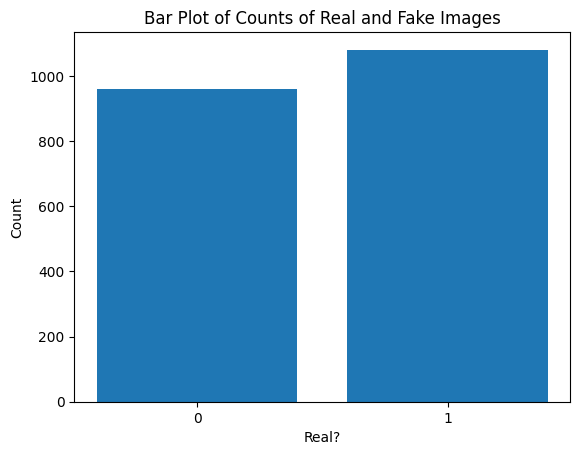

In [ ]:
# Bar Plot for Data Distribution
plt.bar(df['Real'].value_counts().index, df['Real'].value_counts().values)
plt.xlabel('Real?')
plt.ylabel('Count')
plt.title('Bar Plot of Counts of Real and Fake Images')
plt.xticks([0, 1])
plt.show()

In [ ]:
# Preprocess Images
def preprocess_image(path, target_size=(224, 224), color_mode='rgb'):
    img = load_img(path, target_size=target_size, color_mode=color_mode)
    img_array = img_to_array(img)
    return preprocess_input(img_array)

df['image'] = df['Paths'].apply(preprocess_image)

In [ ]:
# Split Dataset
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Real'], random_state=123)
X_train = np.stack(train_df['image'].values)
y_train = train_df['Real'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['Real'].values

In [ ]:
print("ResNet50 model exists:", os.path.exists("drive/MyDrive/savedModels/final_yonsei_models/ResNet50.h5"))
print("DenseNet model exists:", os.path.exists("drive/MyDrive/savedModels/final_yonsei_models/DenseNet121.h5"))
print("EfficientNEtB0 model exists:", os.path.exists("drive/MyDrive/savedModels/final_yonsei_models/EfficientNetB0.h5"))

ResNet50 model exists: True
DenseNet model exists: True
EfficientNEtB0 model exists: True


In [ ]:
# Load pre-trained models from .h5 files
model_resnet50 = tf.keras.models.load_model("drive/MyDrive/savedModels/final_yonsei_models/ResNet50.h5")
model_densenet = tf.keras.models.load_model("drive/MyDrive/savedModels/final_yonsei_models/DenseNet121.h5")
model_efficientnetB0 = tf.keras.models.load_model("drive/MyDrive/savedModels/final_yonsei_models/EfficientNetB0.h5")

In [ ]:
test_sample = X_test[:5]  # Pick a small batch

try:
    print("ResNet50 Prediction Shape:", model_resnet50.predict(test_sample).shape)
    print("DenseNet Prediction Shape:", model_densenet.predict(test_sample).shape)
    print("EfficientNet Prediction Shape:", model_efficientnetB0.predict(test_sample).shape)
except Exception as e:
    print("Error during individual predictions:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
ResNet50 Prediction Shape: (5, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
DenseNet Prediction Shape: (5, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
EfficientNet Prediction Shape: (5, 1)


In [ ]:
import numpy as np

print("X_test type:", type(X_test))
print("X_test shape:", X_test.shape)
print("X_test dtype:", X_test.dtype)


X_test type: <class 'numpy.ndarray'>
X_test shape: (613, 224, 224, 3)
X_test dtype: float32


In [ ]:
print("ResNet50 output shape:", model_resnet50.output_shape)
print("DenseNet output shape:", model_densenet.output_shape)
print("EfficientNet output shape:", model_efficientnetB0.output_shape)


ResNet50 output shape: (None, 1)
DenseNet output shape: (None, 1)
EfficientNet output shape: (None, 1)


In [ ]:
print("ResNet50 input shape:", model_resnet50.input_shape)
print("DenseNet input shape:", model_densenet.input_shape)
print("EfficientNet input shape:", model_efficientnetB0.input_shape)


ResNet50 input shape: (None, 224, 224, 3)
DenseNet input shape: (None, 224, 224, 3)
EfficientNet input shape: (None, 224, 224, 3)


# Averaging Probability

In [ ]:
def ensemble_predict(model_1, model_2, model_3, X_test, method='average'):
    """
    Generate ensemble predictions using either majority voting or averaging.

    Parameters:
    - model_1: First model (ResNet)
    - model_2: Second model (DenseNet)
    - model_3: Third model (EfficientNet)
    - X_test: Test dataset
    - method: 'average' for probability averaging, 'majority' for majority voting

    Returns:
    - Final binary predictions (0 or 1)
    """
    # Get predictions from all models
    pred_model1 = model_1.predict(X_test)
    pred_model2 = model_2.predict(X_test)
    pred_model3 = model_3.predict(X_test)

    if method == 'average':
        # Averaging the predicted probabilities
        pred_avg = np.mean([pred_model1, pred_model2, pred_model3], axis=0)
        pred_binary = (pred_avg > 0.5).astype(int)  # Convert probabilities to binary labels
    elif method == 'majority':
        # Majority voting: round to nearest integer and average the predictions
        pred_binary = (np.round(pred_model1) + np.round(pred_model2) + np.round(pred_model3)) // 3
    else:
        raise ValueError("Invalid method. Choose 'average' or 'majority'.")

    return pred_binary

# Load test data (Assuming X_test and y_test are preloaded)
ensemble_preds = ensemble_predict(model_resnet50, model_densenet, model_efficientnetB0, X_test, method='average')

# Evaluate Ensemble Model
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_precision = precision_score(y_test, ensemble_preds)
ensemble_recall = recall_score(y_test, ensemble_preds)
ensemble_f1 = f1_score(y_test, ensemble_preds)

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Precision: {ensemble_precision:.4f}")
print(f"Ensemble Recall: {ensemble_recall:.4f}")
print(f"Ensemble F1-Score: {ensemble_f1:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step
Ensemble Accuracy: 0.5670
Ensemble Precision: 0.5616
Ensemble Recall: 0.8671
Ensemble F1-Score: 0.6817


# Majority Voting

In [ ]:
def ensemble_majority_predict(model_1, model_2, model_3, X_test):
    """
    Generate ensemble predictions using majority voting.

    Parameters:
    - model_1: First model (ResNet)
    - model_2: Second model (DenseNet)
    - model_3: Third model (EfficientNet)
    - X_test: Test dataset

    Returns:
    - Final binary predictions (0 or 1)
    """
    # Get predictions from all models
    pred_model1 = np.round(model_1.predict(X_test))
    pred_model2 = np.round(model_2.predict(X_test))
    pred_model3 = np.round(model_3.predict(X_test))

    # Majority voting
    pred_binary = (pred_model1 + pred_model2 + pred_model3) // 3

    return pred_binary

# Load test data (Assuming X_test and y_test are preloaded)
ensemble_majority_preds = ensemble_majority_predict(model_resnet50, model_densenet, model_efficientnetB0, X_test)

# Evaluate Ensemble Model
ensemble_majority_accuracy = accuracy_score(y_test, ensemble_majority_preds)
ensemble_majority_precision = precision_score(y_test, ensemble_majority_preds)
ensemble_majority_recall = recall_score(y_test, ensemble_majority_preds)
ensemble_majority_f1 = f1_score(y_test, ensemble_majority_preds)

print(f"Ensemble Majority Accuracy: {ensemble_majority_accuracy:.4f}")
print(f"Ensemble Majority Precision: {ensemble_majority_precision:.4f}")
print(f"Ensemble Majority Recall: {ensemble_majority_recall:.4f}")
print(f"Ensemble Majority F1-Score: {ensemble_majority_f1:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step
Ensemble Majority Accuracy: 0.5977
Ensemble Majority Precision: 0.7384
Ensemble Majority Recall: 0.3837
Ensemble Majority F1-Score: 0.5050


# Weighted Majority Voting

In [ ]:
def ensemble_weighted_voting(model_1, model_2, model_3, X_test, weight_1=0.6, weight_2=0.3, weight_3=0.1):
    """
    Generate ensemble predictions using weighted voting.

    Parameters:
    - model_1: First model (ResNet)
    - model_2: Second model (DenseNet)
    - model_3: Third model (EfficientNet)
    - X_test: Test dataset
    - weight_1: Weight for model_1's predictions
    - weight_2: Weight for model_2's predictions
    - weight_3: Weight for model_3's predictions

    Returns:
    - Final binary predictions (0 or 1)
    """
    # Get predictions from all models
    pred_model1 = model_1.predict(X_test)
    pred_model2 = model_2.predict(X_test)
    pred_model3 = model_3.predict(X_test)

    # Weighted predictions
    weighted_preds = np.average([pred_model1, pred_model2, pred_model3], axis=0, weights=[weight_1, weight_2, weight_3])
    pred_binary = (weighted_preds > 0.5).astype(int)  # Convert weighted probability to binary label

    return pred_binary

# Load test data and evaluate
ensemble_weighted_preds = ensemble_weighted_voting(model_resnet50, model_densenet, model_efficientnetB0, X_test)
ensemble_weighted_accuracy = accuracy_score(y_test, ensemble_weighted_preds)
ensemble_weighted_precision = precision_score(y_test, ensemble_weighted_preds)
ensemble_weighted_recall = recall_score(y_test, ensemble_weighted_preds)
ensemble_weighted_f1 = f1_score(y_test, ensemble_weighted_preds)

print(f"Weighted Majority Voting Accuracy: {ensemble_weighted_accuracy:.4f}")
print(f"Weighted Majority Voting Precision: {ensemble_weighted_precision:.4f}")
print(f"Weighted Majority Voting Recall: {ensemble_weighted_recall:.4f}")
print(f"Weighted Majority Voting F1-Score: {ensemble_weighted_f1:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step
Weighted Majority Voting Accuracy: 0.6107
Weighted Majority Voting Precision: 0.5996
Weighted Majority Voting Recall: 0.8187
Weighted Majority Voting F1-Score: 0.6922


# Stacking

45/45 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
Accuracy: 0.6330
Precision: 0.6471
Recall: 0.6769
F1 Score: 0.6617


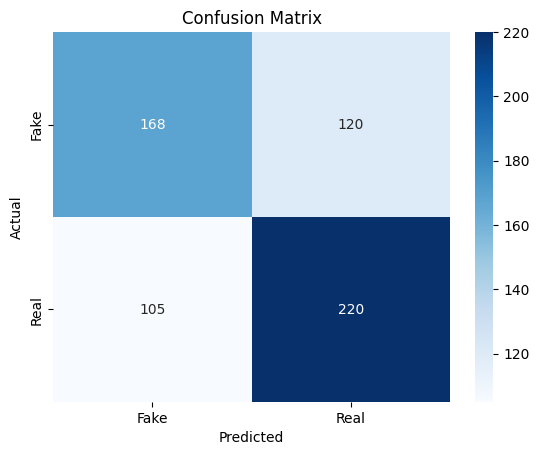

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Extract predictions from base models
def get_predictions(model, X):
    return model.predict(X)

# Get predictions for training and test data
resnet_train_preds = get_predictions(model_resnet50, X_train)
densenet_train_preds = get_predictions(model_densenet, X_train)
efficientnet_train_preds = get_predictions(model_efficientnetB0, X_train)

resnet_test_preds = get_predictions(model_resnet50, X_test)
densenet_test_preds = get_predictions(model_densenet, X_test)
efficientnet_test_preds = get_predictions(model_efficientnetB0, X_test)

# Step 2: Combine predictions horizontally
X_final_train = np.column_stack((resnet_train_preds, densenet_train_preds, efficientnet_train_preds))
X_final_test = np.column_stack((resnet_test_preds, densenet_test_preds, efficientnet_test_preds))

# Step 3: Train the meta-model (Logistic Regression)
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_final_train, y_train)

# Step 4: Evaluate the stacked model
y_pred = meta_model.predict(X_final_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4766 - loss: 0.7059
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5056 - loss: 0.6935
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5197 - loss: 0.6856
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5741 - loss: 0.6760
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5665 - loss: 0.6766
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5506 - loss: 0.6790
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5745 - loss: 0.6747
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5770 - loss: 0.6679
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6033 - loss: 0.6636
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5948 - loss: 0.6635
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6048 - loss: 0.6605
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6225 - loss: 0.6547


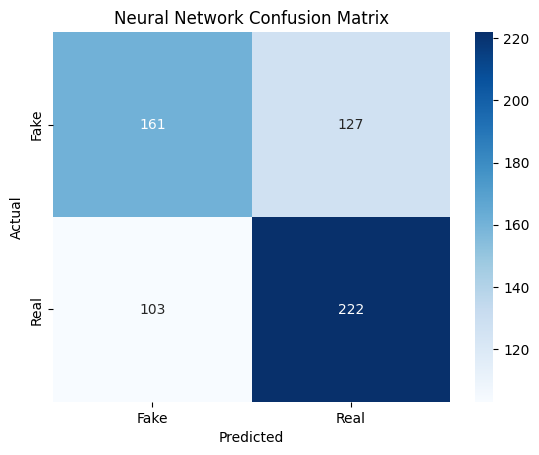

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Step 1: Extract predictions from base models
def get_predictions(model, X):
    return model.predict(X)

# Get predictions for training and test data
resnet_train_preds = get_predictions(model_resnet50, X_train)
densenet_train_preds = get_predictions(model_densenet, X_train)
efficientnet_train_preds = get_predictions(model_efficientnetB0, X_train)

resnet_test_preds = get_predictions(model_resnet50, X_test)
densenet_test_preds = get_predictions(model_densenet, X_test)
efficientnet_test_preds = get_predictions(model_efficientnetB0, X_test)

# Step 2: Combine predictions horizontally
X_final_train = np.column_stack((resnet_train_preds, densenet_train_preds, efficientnet_train_preds))
X_final_test = np.column_stack((resnet_test_preds, densenet_test_preds, efficientnet_test_preds))

### **Meta-Model 2: Neural Network (MLP)**
mlp_meta_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_final_train.shape[1],)),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

mlp_meta_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Neural Network Meta-Model
mlp_meta_model.fit(X_final_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predictions
y_pred_mlp = (mlp_meta_model.predict(X_final_test) > 0.5).astype("int32")

# Evaluation Metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print("\nNeural Network Meta-Model Performance:")
print(f"Accuracy: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1 Score: {f1_mlp:.4f}")

# Confusion Matrix for Neural Network
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5140 - loss: 0.6882
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6145 - loss: 0.6620
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6265 - loss: 0.6465
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6569 - loss: 0.6276
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6218 - loss: 0.6469
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6508 - loss: 0.6293
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6445 - loss: 0.6321
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6422 - loss: 0.6237
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6517 - loss: 0.6207
Epoch 10

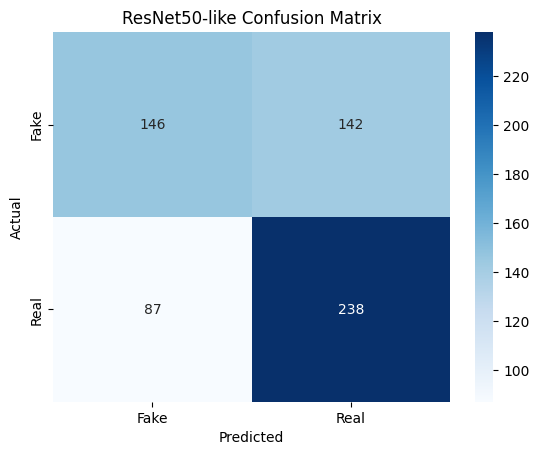

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Step 1: Extract predictions from base models
def get_predictions(model, X):
    return model.predict(X)

# Get predictions for training and test data
resnet_train_preds = get_predictions(model_resnet50, X_train)
densenet_train_preds = get_predictions(model_densenet, X_train)
efficientnet_train_preds = get_predictions(model_efficientnetB0, X_train)

resnet_test_preds = get_predictions(model_resnet50, X_test)
densenet_test_preds = get_predictions(model_densenet, X_test)
efficientnet_test_preds = get_predictions(model_efficientnetB0, X_test)

# Step 2: Combine predictions horizontally
X_final_train = np.column_stack((resnet_train_preds, densenet_train_preds, efficientnet_train_preds))
X_final_test = np.column_stack((resnet_test_preds, densenet_test_preds, efficientnet_test_preds))

### **Meta-Model: ResNet50-like MLP**
inputs = Input(shape=(X_final_train.shape[1],))

# ResNet50-inspired dense layers
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the Model
resnet_meta_model = Model(inputs=inputs, outputs=outputs)

# Compile Model
resnet_meta_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train ResNet-like Meta-Model
resnet_meta_model.fit(X_final_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predictions
y_pred_resnet = (resnet_meta_model.predict(X_final_test) > 0.5).astype("int32")

# Evaluation Metrics
accuracy_resnet = accuracy_score(y_test, y_pred_resnet)
precision_resnet = precision_score(y_test, y_pred_resnet)
recall_resnet = recall_score(y_test, y_pred_resnet)
f1_resnet = f1_score(y_test, y_pred_resnet)

print("\nResNet50-like Meta-Model Performance:")
print(f"Accuracy: {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet:.4f}")
print(f"Recall: {recall_resnet:.4f}")
print(f"F1 Score: {f1_resnet:.4f}")

# Confusion Matrix for ResNet Meta-Model
conf_matrix_resnet = confusion_matrix(y_test, y_pred_resnet)
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ResNet50-like Confusion Matrix')
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5154 - loss: 0.6899
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6179 - loss: 0.6632
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.6475
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6511 - loss: 0.6336
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6555 - loss: 0.6309
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 0.6255
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6552 - loss: 0.6230
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6762 - loss: 0.6106
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 0.6346
Epoch 10

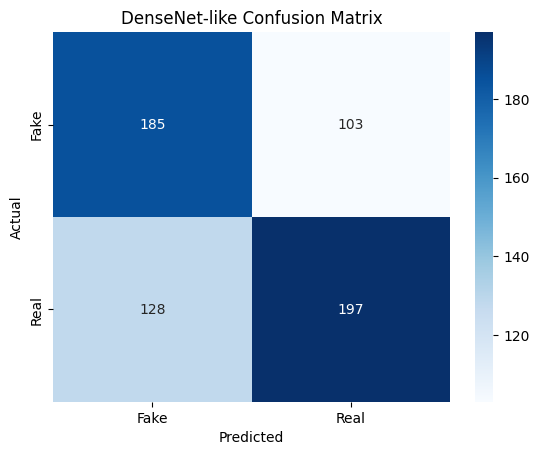

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

# Step 1: Extract predictions from base models
def get_predictions(model, X):
    return model.predict(X)

# Get predictions for training and test data
resnet_train_preds = get_predictions(model_resnet50, X_train)
densenet_train_preds = get_predictions(model_densenet, X_train)
efficientnet_train_preds = get_predictions(model_efficientnetB0, X_train)

resnet_test_preds = get_predictions(model_resnet50, X_test)
densenet_test_preds = get_predictions(model_densenet, X_test)
efficientnet_test_preds = get_predictions(model_efficientnetB0, X_test)

# Step 2: Combine predictions horizontally
X_final_train = np.column_stack((resnet_train_preds, densenet_train_preds, efficientnet_train_preds))
X_final_test = np.column_stack((resnet_test_preds, densenet_test_preds, efficientnet_test_preds))

### **Meta-Model: DenseNet-like MLP**
inputs = Input(shape=(X_final_train.shape[1],))

# DenseNet-inspired dense layers
x = Dense(256, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the Model
densenet_meta_model = Model(inputs=inputs, outputs=outputs)

# Compile Model
densenet_meta_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train DenseNet-like Meta-Model
densenet_meta_model.fit(X_final_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predictions
y_pred_densenet = (densenet_meta_model.predict(X_final_test) > 0.5).astype("int32")

# Evaluation Metrics
accuracy_densenet = accuracy_score(y_test, y_pred_densenet)
precision_densenet = precision_score(y_test, y_pred_densenet)
recall_densenet = recall_score(y_test, y_pred_densenet)
f1_densenet = f1_score(y_test, y_pred_densenet)

print("\nDenseNet-like Meta-Model Performance:")
print(f"Accuracy: {accuracy_densenet:.4f}")
print(f"Precision: {precision_densenet:.4f}")
print(f"Recall: {recall_densenet:.4f}")
print(f"F1 Score: {f1_densenet:.4f}")

# Confusion Matrix for DenseNet Meta-Model
conf_matrix_densenet = confusion_matrix(y_test, y_pred_densenet)
sns.heatmap(conf_matrix_densenet, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DenseNet-like Confusion Matrix')
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5286 - loss: 0.6896
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5872 - loss: 0.6669
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6325 - loss: 0.6416
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6226 - loss: 0.6472
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.6461
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6473 - loss: 0.6318
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6360 - loss: 0.6395
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6256
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6497 - loss: 0.6238
Epoch 10

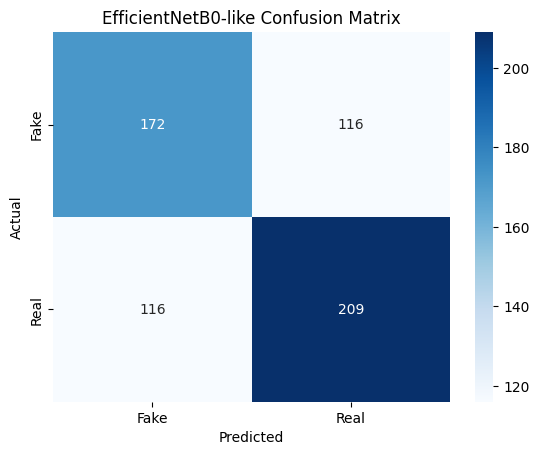

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Step 1: Extract predictions from base models
def get_predictions(model, X):
    return model.predict(X)

# Get predictions for training and test data
resnet_train_preds = get_predictions(model_resnet50, X_train)
densenet_train_preds = get_predictions(model_densenet, X_train)
efficientnet_train_preds = get_predictions(model_efficientnetB0, X_train)

resnet_test_preds = get_predictions(model_resnet50, X_test)
densenet_test_preds = get_predictions(model_densenet, X_test)
efficientnet_test_preds = get_predictions(model_efficientnetB0, X_test)

# Step 2: Combine predictions horizontally
X_final_train = np.column_stack((resnet_train_preds, densenet_train_preds, efficientnet_train_preds))
X_final_test = np.column_stack((resnet_test_preds, densenet_test_preds, efficientnet_test_preds))

### **Meta-Model: EfficientNetB0-like MLP**
inputs = Input(shape=(X_final_train.shape[1],))

# EfficientNet-inspired dense layers
x = Dense(256, activation='swish')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='swish')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the Model
efficientnet_meta_model = Model(inputs=inputs, outputs=outputs)

# Compile Model
efficientnet_meta_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train EfficientNetB0-like Meta-Model
efficientnet_meta_model.fit(X_final_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predictions
y_pred_efficientnet = (efficientnet_meta_model.predict(X_final_test) > 0.5).astype("int32")

# Evaluation Metrics
accuracy_efficientnet = accuracy_score(y_test, y_pred_efficientnet)
precision_efficientnet = precision_score(y_test, y_pred_efficientnet)
recall_efficientnet = recall_score(y_test, y_pred_efficientnet)
f1_efficientnet = f1_score(y_test, y_pred_efficientnet)

print("\nEfficientNetB0-like Meta-Model Performance:")
print(f"Accuracy: {accuracy_efficientnet:.4f}")
print(f"Precision: {precision_efficientnet:.4f}")
print(f"Recall: {recall_efficientnet:.4f}")
print(f"F1 Score: {f1_efficientnet:.4f}")

# Confusion Matrix for EfficientNet Meta-Model
conf_matrix_efficientnet = confusion_matrix(y_test, y_pred_efficientnet)
sns.heatmap(conf_matrix_efficientnet, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('EfficientNetB0-like Confusion Matrix')
plt.show()


In [ ]:
# stacking PCA and SVC Learning Ensemble
def transfer_learning_ensemble(model_1, model_2, model_3, X_train, X_test, y_train):
    feature_extractor_model1 = tf.keras.Model(inputs=model_1.input, outputs=model_1.layers[-2].output)
    feature_extractor_model2 = tf.keras.Model(inputs=model_2.input, outputs=model_2.layers[-2].output)
    feature_extractor_model3 = tf.keras.Model(inputs=model_3.input, outputs=model_3.layers[-2].output)
    features_train_1 = feature_extractor_model1.predict(X_train)
    features_train_2 = feature_extractor_model2.predict(X_train)
    features_train_3 = feature_extractor_model3.predict(X_train)
    features_test_1 = feature_extractor_model1.predict(X_test)
    features_test_2 = feature_extractor_model2.predict(X_test)
    features_test_3 = feature_extractor_model3.predict(X_test)
    stacked_train_features = np.hstack((features_train_1, features_train_2, features_train_3))
    stacked_test_features = np.hstack((features_test_1, features_test_2, features_test_3))
    pca = PCA(n_components=100)
    stacked_train_features = pca.fit_transform(stacked_train_features)
    stacked_test_features = pca.transform(stacked_test_features)
    meta_model = SVC(kernel='rbf', probability=True)
    meta_model.fit(stacked_train_features, y_train)
    train_preds = meta_model.predict(stacked_train_features)
    test_preds = meta_model.predict(stacked_test_features)
    return train_preds, test_preds

train_preds_transfer, test_preds_transfer = transfer_learning_ensemble(model_resnet50, model_densenet, model_efficientnetB0, X_train, X_test, y_train)

print("\nTransfer Learning - Training Metrics:")
print(f"Accuracy: {accuracy_score(y_train, train_preds_transfer):.4f}")
print(f"Precision: {precision_score(y_train, train_preds_transfer):.4f}")
print(f"Recall: {recall_score(y_train, train_preds_transfer):.4f}")
print(f"F1-Score: {f1_score(y_train, train_preds_transfer):.4f}")
print("Transfer Learning - Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, test_preds_transfer):.4f}")
print(f"Precision: {precision_score(y_test, test_preds_transfer):.4f}")
print(f"Recall: {recall_score(y_test, test_preds_transfer):.4f}")
print(f"F1-Score: {f1_score(y_test, test_preds_transfer):.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

Transfer Learning - Training Metrics:
Accuracy: 0.7276
Precision: 0.7192
Recall: 0.7963
F1-Score: 0.7558
Transfer Learning - Test Metrics:
Accuracy: 0.5318
Precision: 0.5531
Recall: 0.6092
F1-Score: 0.5798
